## Agricultural Production



### Preface



Some packages we need to have installed (skip this if already installed):



In [1]:
%pip install plotly
%pip install wbdata
%pip install cufflinks
%pip install eep153_tools

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Malthus



Among all the things ever written by social scientists (or &ldquo;political philosophers&rdquo;, to use a term he would have recognized), Malthus&rsquo; [&ldquo;Essay on Population&rdquo; (1798)](https://oll.libertyfund.org/titles/malthus-an-essay-on-the-principle-of-population-1798-1st-ed) must be among the most influential.  You can find the first edition at the link above. The main argument is spelled out in Chapter 1, which I encourage you to read.  A key point of the essay begins with [two postulata](https://oll.libertyfund.org/titles/311#Malthus_0195_20):

-   **First:** That food is necessary to the existence of man.
-   **Secondly:** That the passion between the sexes is necessary and will remain nearly in its present state.

These lead to a conclusion:

>     Assuming then, my postulata as granted, I say, that the power of
>     population is indefinitely greater than the power in the earth to
>     produce subsistence for man.  Population, when unchecked, increases
>     in a geometrical ratio. Subsistence increases only in an
>     arithmetical ratio. A slight acquaintance with numbers will shew
>     the immensity of the first power in comparison of the second.



#### Malthus meets math



Malthus&rsquo; argument boils down to a mathematical assertion: that
    population grows at an exponential rate, while food production
    increases only linearly.  We might write this as
    $$
       \mbox{Population}_t = \mbox{Population}_0e^{rt},
    $$
    where $r$ is the rate of population growth, and $t$ is the number
    of years that have passed; and
   $$
       \mbox{Food}_t = \mbox{Food}_0 + mt.
    $$
    If we lack a &ldquo;slight acquaintance&rdquo; with numbers a graph makes the
    point:



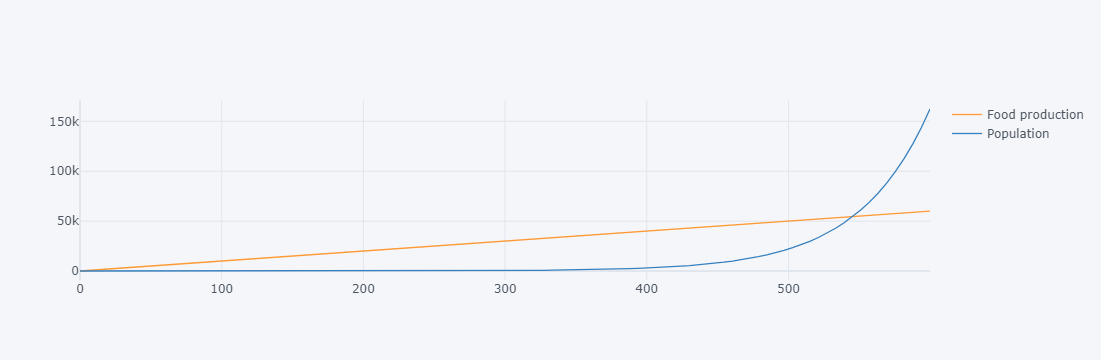

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import newton
import cufflinks as cf
cf.go_offline()

# Play with these constants
## for exponential
P0 = 1
r = 0.02  # Rate of population growth

## for line
F0 = 10
m = 100

def food_production(t,m=m):
    return F0+m*t

def population(t,r=r):
    return P0*np.exp(r*t)

def choose_xaxis(r,m,x0=10):
    """
    Find a range of x so that curves intersect
    """
    tstar = -1
    try:
        while tstar <= 0:
            tstar = newton(lambda t: food_production(t,m) - population(t,r),x0,maxiter=1000)
            x0 = x0*10
        return np.linspace(0,tstar*1.1,100)
    except RuntimeError: # Failed to find root
        return np.linspace(0,1000,100)

T = choose_xaxis(r,m)

df = pd.DataFrame({'Time': T,
                   'Food production':[food_production(t) for t in T],
                   'Population':[population(t) for t in T]}).set_index('Time')

df.iplot()

### Food Production



Malthus thought that population would have to increase at an exponential rate.  We&rsquo;ve seen that in fact the rate of population increase has been roughly linear over the last six decades. (There are no guarantees about the future!)

Malthus also thought that food production (&ldquo;subsistence&rdquo;) could only increase linearly (&ldquo;arithmetically&rdquo;).  We&rsquo;ll next take a look to see what the data say about this.



#### Preface



In [3]:
import numpy as np
import wbdata
import cufflinks as cf
cf.go_offline()

def fix_date_index(df):
    idx_vars = df.index.names
    new = df.reset_index()
    new.date = new.date.astype(int)
    return new.set_index(idx_vars)

#### Finding data



Maybe there&rsquo;s something relevant to food production in the WDI indicators?



In [4]:
wbdata.get_topic()

  id  value
----  -------------------------------
   1  Agriculture & Rural Development
   2  Aid Effectiveness
   3  Economy & Growth
   4  Education
   5  Energy & Mining
   6  Environment
   7  Financial Sector
   8  Health
   9  Infrastructure
  10  Social Protection & Labor
  11  Poverty
  12  Private Sector
  13  Public Sector
  14  Science & Technology
  15  Social Development
  16  Urban Development
  17  Gender
  18  Millenium development goals
  19  Climate Change
  20  External Debt
  21  Trade

&ldquo;Agriculture & Rural Development&rdquo; sounds relevant.  Let&rsquo;s see what variables are available:



In [5]:
wbdata.get_indicator(topic=1)

id                    name
--------------------  ------------------------------------------------------------------------------------------
AG.AGR.TRAC.NO        Agricultural machinery, tractors
AG.CON.FERT.PT.ZS     Fertilizer consumption (% of fertilizer production)
AG.CON.FERT.ZS        Fertilizer consumption (kilograms per hectare of arable land)
AG.LND.AGRI.K2        Agricultural land (sq. km)
AG.LND.AGRI.ZS        Agricultural land (% of land area)
AG.LND.ARBL.HA        Arable land (hectares)
AG.LND.ARBL.HA.PC     Arable land (hectares per person)
AG.LND.ARBL.ZS        Arable land (% of land area)
AG.LND.CREL.HA        Land under cereal production (hectares)
AG.LND.CROP.ZS        Permanent cropland (% of land area)
AG.LND.EL5M.RU.K2     Rural land area where elevation is below 5 meters (sq. km)
AG.LND.EL5M.RU.ZS     Rural land area where elevation is below 5 meters (% of total land area)
AG.LND.FRST.K2        Forest area (sq. km)
AG.LND.FRST.ZS        Forest area (% of land area)

#### Cereal production & land



The great majority of food (as measured by calories) originates in the form of cereals; some of these are turned into products directly consumed by humans (bread, rice, hominy); others are used to feed livestock, which humans subsequently eat.  So what&rsquo;s happened to cereal production over the last few decades?



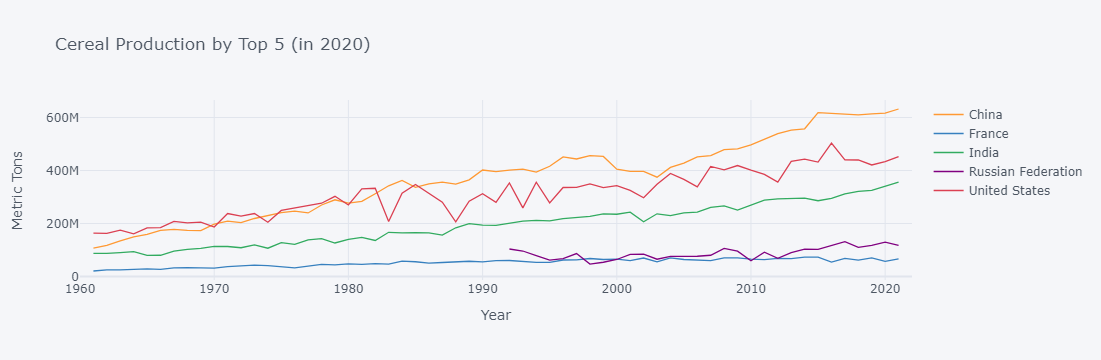

In [6]:
vars = {"AG.PRD.CREL.MT":"Cereal production"}


use=["CHN","USA","IND","FRA","RUS"]

cereals = fix_date_index(wbdata.get_dataframe(vars,country=use)).squeeze().unstack('country')

# Use this to find top producers:
#big_producers = cereals.query('date==2020').squeeze().sort_values(ascending=False)
#big_producers.head(20)

cereals.iplot(xTitle="Year",yTitle="Metric Tons",
              title="Cereal Production by Top 5 (in 2020)")

#### FAO Food Index



The FAO compiles a series of data meant to measure changes in the supply of food of all sorts, including both plant and animal sources.

From this we don&rsquo;t get levels; instead the series is normalized to an arbitrary year.  Let&rsquo;s let each series take the value of 100 in the year 2000, and compare this with a similarly normalized description of world population:



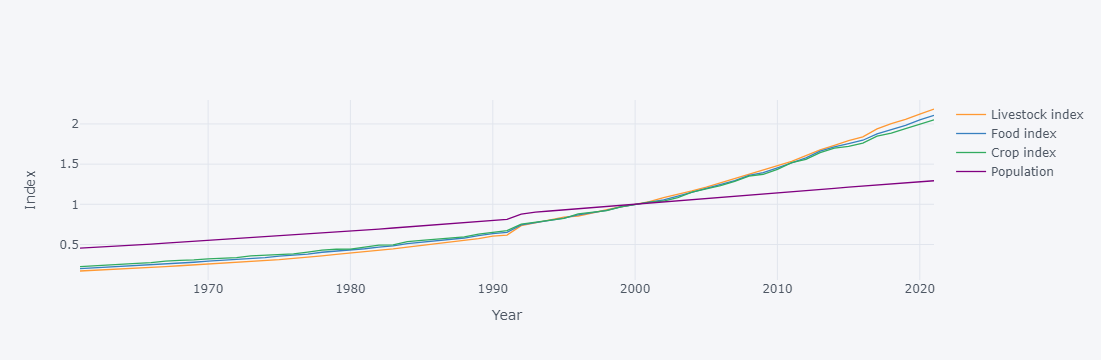

In [7]:
vars = {"AG.PRD.LVSK.XD":"Livestock index",
        "AG.PRD.FOOD.XD":"Food index",
        "AG.PRD.CROP.XD":"Crop index",
        "SP.POP.TOTL":"Population"}

food = fix_date_index(wbdata.get_dataframe(vars)).dropna()
# Add population back...
Population = food.Population

# Weight indices by population
food = food.filter(regex='index$').multiply(Population,axis=0)

food['Population'] = Population

# No "WLD" or other regions; add up all countries
food = food.groupby('date').sum().replace(0,np.nan).dropna()

food.sort_index(inplace=True)

# Normalize so 2000 = 1
food = food/food.loc[2000,:]

food.iplot(xTitle="Year",yTitle="Index")

And here in growth rates:



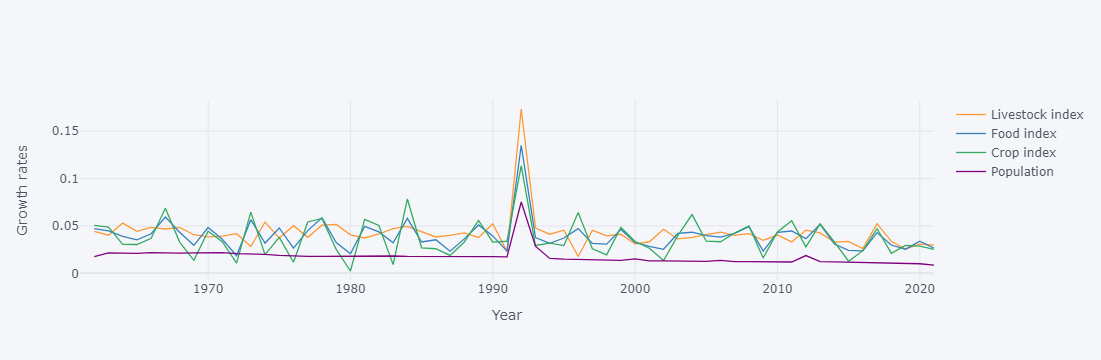

In [8]:
np.log(food).diff().iplot(xTitle="Year",yTitle="Growth rates")

### How is agricultural production increasing?



We&rsquo;ve seen that growth in food production is typically greater than
 population growth.  But where is this growth coming from?

Food (and crops in particular) are the classical example of
production.  The &ldquo;classical&rdquo; economists in the 18th century, when
most income came from agriculture, thought there were three main
&ldquo;factors&rdquo; of production:

-   Land
-   Labor
-   Capital

Thus one might write the technical relationship between &ldquo;factors&rdquo; (or
inputs) and output as
$$
    \text{Crop output} = F(\mbox{Land},\mbox{Labor},\mbox{Capital}).
 $$



### Functional forms



We have good reason to think that $F$ displays constant returns to
  scale; i.e., is homogeneous of degree one.  Write it as
  $F(x_1,x_2,\dots,x_n)$ (thus abstracting from the classical factors
  of production).

Observationally, it&rsquo;s also often the case the cost share for
different factors of production remains constant, even when prices
change.  If we combine these facts (linearly homogeneous, constant
cost shares) with an assumption that farmers operating this
production function are profit maximizing price-takers and a
technical assumption that $F$ is continuously differentiable, then
one can prove that $F$ is &ldquo;Cobb-Douglas&rdquo;, or
$$
      F(x_1,x_2,\dots,x_n) = A\prod_{i=1}^nx_i^{\alpha_i},
  $$
where $\sum_{i=1}^n\alpha_i=1$.  This is a result first established
by the economist Paul Douglas and the mathematician Charles Cobb in 1928.

If we observe output at time $t$ for country $j$, say $y^j_t$ and inputs $x^j_{it}$, we can take the
logarithm of the Cobb-Douglas production function, obtaining
$$
     \log y^j_t = \log A^j_t + \sum_{i=1}^n\alpha^j_i\log(x^j_{it}).
  $$
Note that we&rsquo;ve allowed the cost-share parameters $\alpha$ to vary
across both inputs and also countries, but *not* over time.



### Total Factor Productivity



The term $A$ is sometimes called &ldquo;Total Factor Productivity&rdquo; (TFP),
   because increases in $A$ increase productivity of all factors.  If
   we take differences in log output over time we get
   $$
      \Delta\log y^j_t = \Delta\log A^j_t + \sum_{i=1}^n\alpha^j_i\Delta\log(x^j_{it}).
   $$
   Recall that changes in logs approximate percent changes or growth
   rates, so we can use this equation to decompose output growth into
   growth in input use and TFP growth.



### Data on Food Production



What’s happened to food production over recent decades?
 See
 [https://www.ers.usda.gov/data-products/international-agricultural-productivity/](https://www.ers.usda.gov/data-products/international-agricultural-productivity/).

Data on TFP, output, factor use, and factor shares can be found at
[https://docs.google.com/spreadsheets/d/1IL9BYacvhs6oIOAnp2KWYdTsoqIqReA2jGRlpheB9kQ/](https://docs.google.com/spreadsheets/d/1IL9BYacvhs6oIOAnp2KWYdTsoqIqReA2jGRlpheB9kQ/),
which is publicly readable.



### Reading Sheets



I&rsquo;ve written a python package `eep153_tools` which includes tools to
handle authentication as well as reading google sheets as pandas
DataFrames.  First we have to deal with authentication, by decrypting
credentials to access particular files (you should only have to do
this part once):



In [11]:
%pip install eep153_tools
%pip install python_gnupg

from eep153_tools.sheets import decrypt_credentials
decrypt_credentials('../students.json.gpg')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Input secret passphrase for ../students.json.gpg to create google drive credentials:  noodle octopus


To check that this worked, the following gives a list of
emails for &ldquo;service<sub>accounts</sub>&rdquo; that now have credentials&#x2013;you can
then &ldquo;share&rdquo; google sheets with these.



In [12]:
!ls ~/.eep153.service_accounts/

students@eep153.iam.gserviceaccount.com


#### With those credentials established



In [13]:
from eep153_tools.sheets import read_sheets
from functools import cache
import pandas as pd

@cache
def get_ag_data():
    """Read a bunch of google worksheets into a dictionary of dataframes"""
    data = read_sheets('https://docs.google.com/spreadsheets/d/1IL9BYacvhs6oIOAnp2KWYdTsoqIqReA2jGRlpheB9kQ/',sheet='Wide format data')

    Data = {'Country':'Country/territory','WDI Code':'ISO3','Year':'Year','Output':'Outall_Index','TFP':'TFP_Index','Land':'Land_Index','Labor':'Labor_Index','Capital':'Capital_Index','Materials':'Materials_Index'}

    df = data.rename(columns={v:k for k,v in Data.items()})
    df = df[Data.keys()].set_index(['WDI Code','Country','Year'])

    # Deal with some duplicate indices (drops regions)
    df = df.loc[~df.index.duplicated(),:]

    return df

### Visualizing data on ag production



Plot growth in output for all countries for 1961 on:



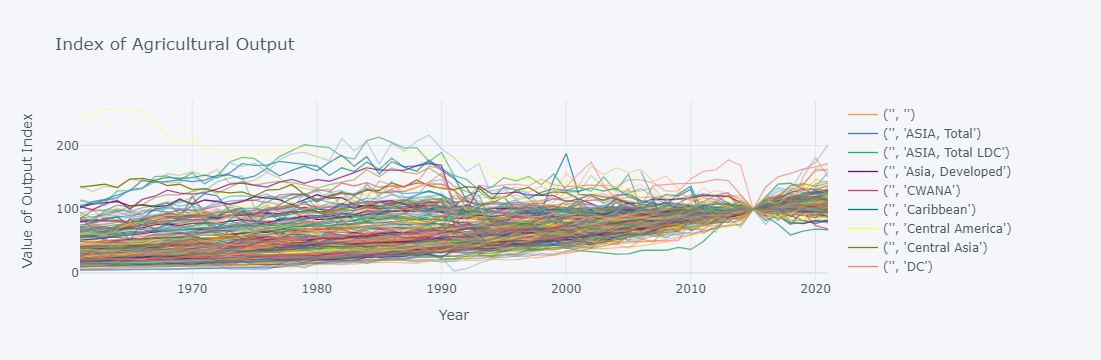

In [16]:
#% pip install cufflinks
import cufflinks as cf
cf.go_offline()

df = get_ag_data()

df['Output'].unstack().T.iplot(title="Index of Agricultural Output",
                               yTitle='Value of Output Index',
                               xTitle='Year')

Compare world growth in outputs, inputs, and TFP:



In [17]:
import numpy as np

world = df.xs('World',level='Country').replace(0,np.nan).dropna(how='any')

# Drop unnecessary index levels
world = world.droplevel(['WDI Code'])

# Put in log differences
dworld = np.log(world).diff()
dworld['Inputs'] = dworld['Output'] - dworld['TFP']

dworld.mean()

Output       0.023372
TFP          0.010128
Land         0.004662
Labor        0.005006
Capital      0.020385
Materials    0.023785
Inputs       0.013243
dtype: float64

And a graph of growth rates:



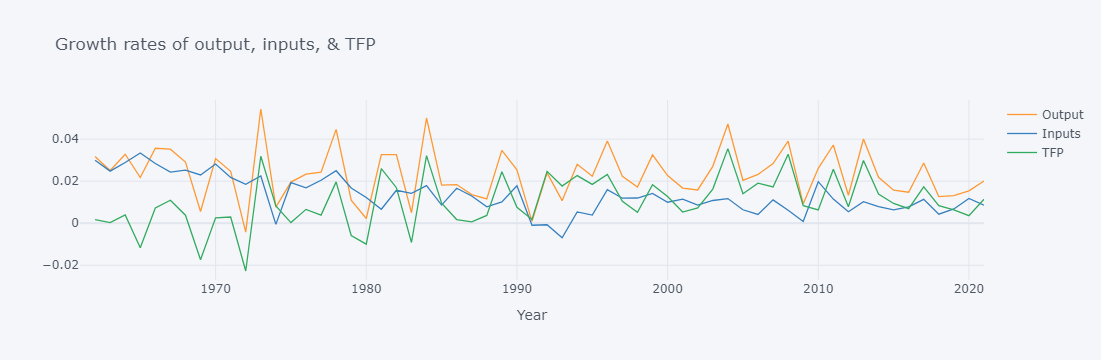

In [18]:
dworld[['Output','Inputs','TFP']].iplot(title="Growth rates of output, inputs, & TFP",
                                           xTitle="Year")

That&rsquo;s the overall picture for the world.  Now &ldquo;drill down&rdquo; and
consider just production in the US:



In [19]:
select = df.xs('USA',level='WDI Code').dropna(how='any')

# Drop unnecessary index levels
select = select.droplevel(['Country'])

dselect = np.log(select).diff()
dselect['Inputs'] = dselect['Output'] - dselect['TFP']

dselect.mean()

Output       0.014984
TFP          0.011869
Land        -0.000645
Labor       -0.011231
Capital      0.008309
Materials    0.009062
Inputs       0.003116
dtype: float64

And here a graph of growth in indices of inputs & outputs since 1961:



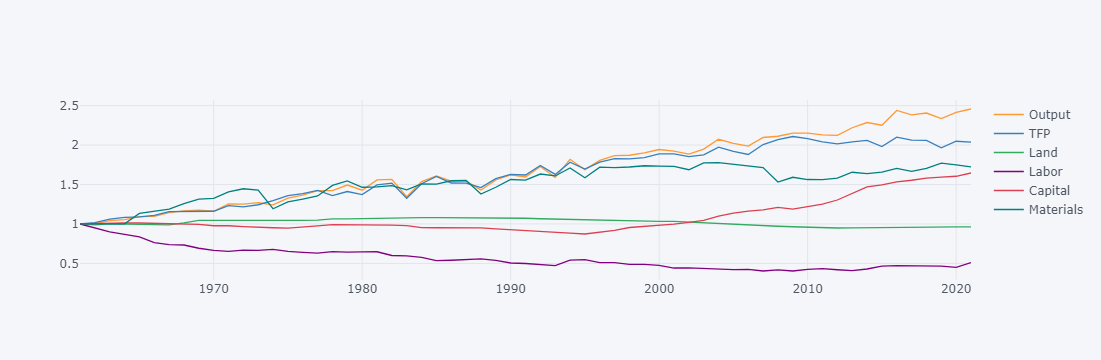

In [20]:
select = df.xs('USA',level='WDI Code').dropna(how='any').droplevel(['Country'])

select = select/select.loc[1961,:]
select.iplot()

Compare with India, which in recent years has had a level of
agricultural output close to that of the US:



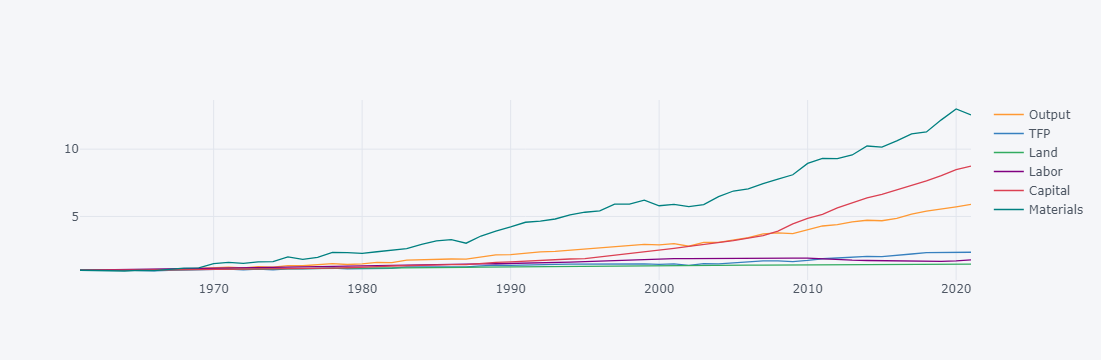

In [25]:
select = df.xs('IND',level='WDI Code').dropna(how='any').droplevel(['Country'])

select = select/select.loc[1961,:]
select.iplot()